In [1]:
"Test different feedback algorithms on "

import itertools
import time

import click
import ipdb  # noqa
import matplotlib.pyplot as plt
import numpy as np
import pathos.multiprocessing as pmp
import sklearn.linear_model as linear_model
import torch
from tqdm import trange
from tqdm import trange
import mi
from models import FADeepFullNet
from utils import errorfill
from tasks import MNISTTask, IBTask, ClippedPolynomialTask
from exp_utils import save_exp_config, setup_result_dir
from models import NnConstructor
from data_utils import get_IB_data
from utils import errorfill

In [4]:
from collections import defaultdict

device = "cuda"
n_repeats = 10
n_samples = 4096
target_feedback_scale = 0.5
dim_in = 12
dim_out = 1
d_hiddens = "8-4"
feedback_option = "TF"
dw_on_output = True

mi_binsize = 0.1

training_data, test_data = get_IB_data(0)
X = training_data.X
y = training_data.y.reshape(-1, 1)

Xt = torch.from_numpy(X).float().to(device)
yt = torch.from_numpy(y).float().to(device)
I = torch.eye(Xt.shape[0]).to(device)

res = defaultdict(lambda: [])
for cond in (True, False):
    for r_idx in range(n_repeats):
        model = FADeepFullNet(
            d_i=dim_in,
            d_o=dim_out,
            d_hiddens=d_hiddens,
            feedback_option=feedback_option,
            dw_decoder_on=dw_on_output,
            output_act_f=NnConstructor.construct_fixpoint(),
            backbone_net_f=None,
            nfa_amp=1e-3,
            allow_scale_after_act=False,
        )
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

        reg = linear_model.LinearRegression()
        reg.fit(X, y)
        r2_LR = reg.score(X, y)
        r2_LR_ts = []
        losss = []
        i_hys = []
        i_hs = []

        for t in trange(1000):
            optimizer.zero_grad()
            y_pred, activities = model(Xt, retain_act_grad=True)
            H = activities[-2]
            if cond is True:
                loss_entropy_H = -torch.log(
                    torch.det(
                        torch.eye(H.shape[0]).to(device) +
                        H.shape[1] / H.shape[0] * H @ H.T))
                # H_norm_sq = (H**2).sum(dim=1).unsqueeze(1)
                # cov_m = H @ H.T / torch.sqrt(H_norm_sq @ H_norm_sq.T)
                # loss_entropy_H = 100 * torch.nn.functional.mse_loss(cov_m, I)
                loss_entropy_H.backward(retain_graph=True)

            H_np = H.data.cpu().numpy()
            i_hys.append(mi.binned_mi(H_np, y, binsize=mi_binsize))
            i_hs.append(mi.binned_entropy(H_np, binsize=mi_binsize))
            reg.fit(H_np, y)

            r2_LR_ts.append(reg.score(H_np, y))
            fb_signal = target_feedback_scale * yt

            y_pred.backward(fb_signal)
            model.clear_decoder_grads()

            y_pred_2 = model.decode(H.data.detach())
            loss = torch.nn.functional.mse_loss(y_pred_2, yt)
            loss.backward()

            optimizer.step()
            losss.append(loss.item())

        res[cond].append({
            "r2_LR": r2_LR,
            "r2_LR_ts": np.array(r2_LR_ts),
            "losss": np.array(losss),
            "i_hys": np.array(i_hys),
            "i_hs": np.array(i_hs),
        })

res_sum = {}
for cond_key in res.keys():
    res_sum[cond_key] = {
        "r2_LR":
        res[cond_key][0]['r2_LR'],
        "r2_LR_ts":
        np.concatenate(
            [np.expand_dims(r["r2_LR_ts"], 0) for r in res[cond_key]], axis=0),
        "losss":
        np.concatenate([np.expand_dims(r["losss"], 0) for r in res[cond_key]],
                       axis=0),
        "i_hys":
        np.concatenate([np.expand_dims(r["i_hys"], 0) for r in res[cond_key]],
                       axis=0),
        "i_hs":
        np.concatenate([np.expand_dims(r["i_hs"], 0) for r in res[cond_key]],
                       axis=0)
    }

res_sum[cond_key]['r2_LR_ts'].shape


100%|██████████| 1000/1000 [00:10<00:00, 94.85it/s]


(10, 1000)

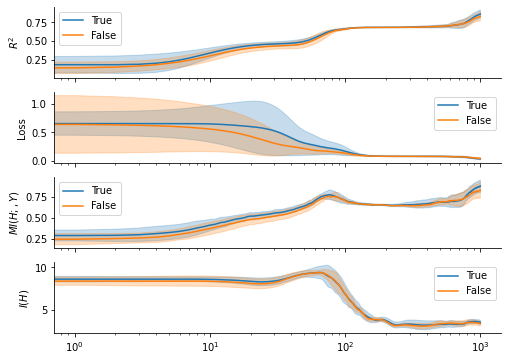

In [5]:
fig, axes = plt.subplots(4, 1, figsize=[8, 6], sharex=True, sharey='row')
for cond in (True, False):
    res_single = res_sum[cond]
    _r2_LR = res_single['r2_LR']
    _r2_LR_ts = res_single['r2_LR_ts']
    _losss = res_single['losss']
    _i_hys = res_single['i_hys']
    _i_hs = res_single['i_hs']
    xs = np.arange(len(r2_LR_ts))

    ax_r2 = axes[0]
    ax_loss = axes[1]
    ax_mi = axes[2]
    ax_ih = axes[3]
    label = f"{cond}"

    errorfill(
        xs,
        _r2_LR_ts.mean(axis=0),
        _r2_LR_ts.std(axis=0),
        ax=ax_r2,
        label=label,
    )
    ax_r2.set_ylabel("$R^2$")

    errorfill(
        xs,
        _losss.mean(axis=0),
        _losss.std(axis=0),
        ax=ax_loss,
        label=label,
    )
    ax_loss.set_ylabel("Loss")

    errorfill(
        xs,
        _i_hys.mean(axis=0),
        _i_hys.std(axis=0),
        ax=ax_mi,
        label=label,
    )
    ax_mi.set_ylabel("$MI(H;,Y)$")

    errorfill(
        xs,
        _i_hs.mean(axis=0),
        _i_hs.std(axis=0),
        ax=ax_ih,
        label=label,
    )

    ax_ih.set_ylabel("$I(H)$")

for ax in axes.flat:
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.set_xscale('log')
    ax.legend()
plt.show()


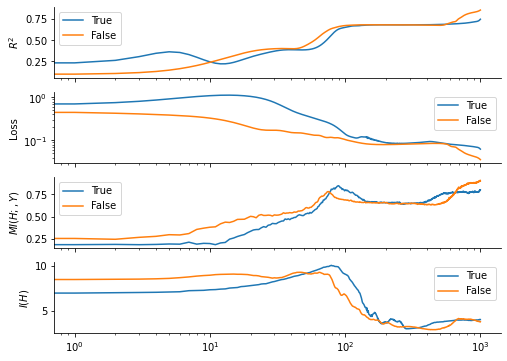

In [16]:
fig, axes = plt.subplots(4, 1, figsize=[8, 6], sharex=True, sharey='row')
for cond in (True, False):
    res_single = res_sum[cond]
    _r2_LR = res_single['r2_LR']
    _r2_LR_ts = res_single['r2_LR_ts'][0]
    _losss = res_single['losss'][0]
    _i_hys = res_single['i_hys'][0]
    _i_hs = res_single['i_hs'][0]
    xs = np.arange(len(r2_LR_ts))

    ax_r2 = axes[0]
    ax_loss = axes[1]
    ax_mi = axes[2]
    ax_ih = axes[3]
    label = f"{cond}"

    ax_r2.plot(xs, _r2_LR_ts, label=label)
    ax_r2.set_ylabel("$R^2$")

    ax_loss.semilogy(xs, _losss, label=label)
    ax_loss.set_ylabel("Loss")

    ax_mi.plot(xs, _i_hys, label=label)

    ax_mi.set_ylabel("$MI(H;,Y)$")
    ax_ih.plot(xs, _i_hs, label=label)
    ax_ih.set_ylabel("$I(H)$")

for ax in axes.flat:
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.set_xscale('log')
    ax.legend()
plt.show()


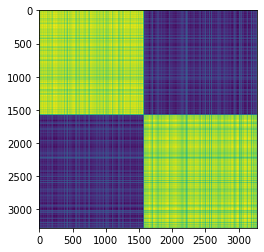

In [17]:
ccov = (H @ H.T).data.cpu().numpy()
idx_sorted = np.argsort(y.reshape(-1))
ccov_sorted = np.zeros_like(ccov)
for new_i, i in enumerate(idx_sorted):
    for new_j, j in enumerate(idx_sorted):
        ccov_sorted[new_i, new_j] = ccov[i, j]
plt.imshow(ccov_sorted)


In [4]:
nz=100
zz1 = np.eye(nz)
zz2 = np.ones((nz, nz))
np.linalg.det(zz2)


0.0

In [6]:
np.linalg.det(zz1) 

1.0